---

## 1. OVERVIEW & METHODOLOGY

# Experiment 0.3: Feature Reduction (Top-k Selection)

**Experiment Phase:** Phase 0 - Setup Fixation  
**Date:** 2026-01-19  
**Author:** Silas Pignotti  
**Expected Runtime:** ~45-60 minutes (1 baseline + 4 variants × 3 folds × ~7-10 min/fold)

---

### 1.1 Purpose

This notebook evaluates **optimal feature count for Phase 1** through systematic feature reduction based on importance rankings.

**Research Question:**  
How many features are optimal for the trade-off between performance, robustness, and efficiency?

**Null Hypothesis (H0):**  
All features (144) perform best - feature reduction degrades performance by >2%.

**Alternative Hypothesis (H1):**  
Feature reduction improves generalization (lower overfitting gap) with <2% performance loss.

---

### 1.2 Workflow

```
[PHASE 1: BASELINE & FEATURE RANKING]
├── Load 20m-Edge dataset (from Experiment 0.2)
├── Train RF with ALL 144 features
├── Extract feature importance (mean over folds)
├── Rank features (highest → lowest importance)
└── Save: exp_0.3_feature_ranking.json

    ↓

[PHASE 2: TOP-K VARIANT TRAINING]
├── Variant A: Top-20 features
├── Variant B: Top-50 features
├── Variant C: Top-80 features
├── Variant D: Top-100 features
└── Variant E: All 144 features (Baseline from Phase 1)

    ↓

[PHASE 3: ANALYSIS & DECISION]
├── Plot Pareto curve (Performance vs. Feature Count)
├── Identify Knee Point
├── Apply decision criteria
└── Select optimal feature set for Phase 1

    ↓

[OUTPUT: Decision + Artifacts]
├── decision_features.md (selected feature set + reasoning)
├── selected_features.json (feature list for Phase 1)
├── exp_0.3_results.json (full results)
├── exp_0.3_feature_ranking.json (all 144 features ranked)
└── 2 PNG plots (Pareto curve + Top-50 importance)
```

### 1.3 Expected Outputs

| File | Type | Description |
|------|------|-------------|
| decision_features.md | Markdown | Selected feature set + reasoning |
| selected_features.json | JSON | Feature list for Phase 1 |
| exp_0.3_results.json | JSON | Full experiment results |
| exp_0.3_feature_ranking.json | JSON | All 144 features ranked by importance |
| exp_0.3_pareto_curve.png | PNG | Performance vs. Feature Count |
| exp_0.3_importance_top50.png | PNG | Top-50 features with importance bars |

### 1.4 Decision Criteria

| Criterion | Condition | Action |
|-----------|-----------|--------|
| **1. Pareto Optimum** | Knee Point in curve | Select feature count at steepest slope decline |
| **2. Performance Retention** | Retention ≥ 98% | Prefer smaller set (efficiency gain) |
| **3. Overfitting Gap** | Gap increases with reduction | Prefer larger set (robustness) |
| **4. Minimal Loss** | Delta < 2% at ≥50% reduction | Select reduced set (Occam's Razor) |

**Where:**  
- Retention = (Top-k Val F1) / (Baseline Val F1)  
- Delta = Baseline Val F1 - Top-k Val F1

---

## 2. IMPORTS & SETUP

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import json
from pathlib import Path
from datetime import datetime

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Publication style configuration
PUBLICATION_STYLE = {
    'style': 'seaborn-v0_8-whitegrid',
    'figsize': (12, 7),
    'dpi_export': 300,
}

def setup_publication_style():
    """Configure matplotlib for publication-quality figures"""
    plt.rcdefaults()
    plt.style.use(PUBLICATION_STYLE['style'])
    sns.set_palette('Set2')
    plt.rcParams['figure.figsize'] = PUBLICATION_STYLE['figsize']
    plt.rcParams['savefig.dpi'] = PUBLICATION_STYLE['dpi_export']
    print("Publication style configured")

setup_publication_style()

# Pandas Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("All imports successful")

Mounted at /content/drive
Publication style configured
✓ All imports successful


### 2.1 Helper Functions

In [2]:
def print_section(title):
    """Print formatted section header."""
    print("\n" + "="*60)
    print(f"  {title}")
    print("="*60 + "\n")

def print_subsection(title):
    """Print formatted subsection header."""
    print("\n" + "-"*60)
    print(f"  {title}")
    print("-"*60 + "\n")

def stratified_sample_by_genus(gdf, n_samples, genus_col='genus_latin', random_state=42):
    """Stratified sampling preserving genus distribution."""
    return gdf.groupby(genus_col, group_keys=False).apply(
        lambda x: x.sample(frac=n_samples/len(gdf), random_state=random_state)
    ).sample(n=min(n_samples, len(gdf)), random_state=random_state)

def train_and_evaluate(X_train, y_train, X_val, y_val, model_config):
    """Train RF and return metrics."""
    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train
    model = RandomForestClassifier(**model_config)
    start_time = datetime.now()
    model.fit(X_train_scaled, y_train)
    train_time = (datetime.now() - start_time).total_seconds()

    # Predict
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)

    # Metrics
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    # Genus-level F1
    genus_f1 = {}
    for genus in np.unique(y_val):
        mask = y_val == genus
        if mask.sum() > 0:
            genus_f1[genus] = f1_score(y_val[mask], y_val_pred[mask], average='macro', zero_division=0)

    return {
        'train_macro_f1': train_f1,
        'val_macro_f1': val_f1,
        'train_val_gap': train_f1 - val_f1,
        'genus_f1': genus_f1,
        'train_time_s': train_time,
        'feature_importance': dict(zip(range(X_train.shape[1]), model.feature_importances_))
    }

print("Helper functions loaded")

✓ Helper functions loaded


---

## 3. CONFIGURATION

### 3.1 Paths

In [3]:
# Base directories (adjust for Colab)
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")
DATA_DIR = BASE_DIR / "data/02_pipeline/05_spatial_splits/data"

# Experiment Output Directories
EXPERIMENT_ID = "03_experiment_feature_reduction"
EXPERIMENT_DIR = BASE_DIR / "data/03_experiments/00_phase_0" / EXPERIMENT_ID

RESULTS_DATA = EXPERIMENT_DIR / "data"
RESULTS_METADATA = EXPERIMENT_DIR / "metadata"
RESULTS_PLOTS = EXPERIMENT_DIR / "plots"

for d in [EXPERIMENT_DIR, RESULTS_DATA, RESULTS_METADATA, RESULTS_PLOTS]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Experiment: {EXPERIMENT_ID}")
print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Experiment directory: {EXPERIMENT_DIR}")

Experiment: 03_experiment_feature_reduction
Base directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit
Data directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/05_spatial_splits/data
Experiment directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/00_phase_0/03_experiment_feature_reduction


### 3.2 Dataset Configuration

In [4]:
# From Experiment 0.2: 20m-Edge dataset selected
DATASET_CONFIG = {
    'city': 'Berlin',
    'dataset': '20m_edge',
    'train_file': 'berlin_20m_edge_train.gpkg',
    'val_file': 'berlin_20m_edge_val.gpkg',
    'expected_genera': 6,
    'sample_size': 50000,
    'stratify_by': 'genus_latin',
    'random_state': 42
}

print("Dataset configuration loaded")
print(f"Dataset: {DATASET_CONFIG['dataset']}")
print(f"Expected genera: {DATASET_CONFIG['expected_genera']}")
print(f"Sample size: {DATASET_CONFIG['sample_size']:,}")

Dataset configuration loaded
Dataset: 20m_edge
Expected genera: 6
Sample size: 50,000


### 3.3 Model Configuration

In [10]:
# Model configuration (consistent with Experiments 0.1 and 0.2)
MODEL_PARAMS = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 0
}

MODEL_NAME = 'RandomForestClassifier'

# CV configuration
CV_CONFIG = {
    'n_splits': 3,
    'type': 'spatial_block',
    'block_size_m': 500,
    'pre_split': True
}

print("Model configuration loaded")
print(f"Model: {MODEL_NAME}")
print(f"CV: {CV_CONFIG['n_splits']}-Fold Spatial Block")

Model configuration loaded
Model: RandomForestClassifier
CV: 3-Fold Spatial Block


### 3.4 Feature Configuration

In [11]:
# From Experiment 0.1: NO CHM features
# 144 spectral features: 8 bands × 8 months + VIs (broadband, red-edge, water) × 8 months

FEATURE_GROUPS = {
    "spectral": [
        *[f"B02_{m:02d}" for m in range(3, 11)],
        *[f"B04_{m:02d}" for m in range(3, 11)],
        *[f"B05_{m:02d}" for m in range(3, 11)],
        *[f"B06_{m:02d}" for m in range(3, 11)],
        *[f"B08_{m:02d}" for m in range(3, 11)],
        *[f"B8A_{m:02d}" for m in range(3, 11)],
        *[f"B11_{m:02d}" for m in range(3, 11)],
        *[f"B12_{m:02d}" for m in range(3, 11)],
    ],
    "vi_broadband": [
        *[f"NDVI_{m:02d}" for m in range(3, 11)],
        *[f"EVI_{m:02d}" for m in range(3, 11)],
        *[f"VARI_{m:02d}" for m in range(3, 11)],
    ],
    "vi_rededge": [
        *[f"NDVIre_{m:02d}" for m in range(3, 11)],
        *[f"NDre1_{m:02d}" for m in range(3, 11)],
        *[f"CIre_{m:02d}" for m in range(3, 11)],
        *[f"IRECI_{m:02d}" for m in range(3, 11)],
        *[f"RTVIcore_{m:02d}" for m in range(3, 11)],
    ],
    "vi_water": [
        *[f"NDWI_{m:02d}" for m in range(3, 11)],
        *[f"NDII_{m:02d}" for m in range(3, 11)],
    ]
}

# Combine all spectral features (NO CHM!)
ALL_FEATURES = (
    FEATURE_GROUPS['spectral'] +
    FEATURE_GROUPS['vi_broadband'] +
    FEATURE_GROUPS['vi_rededge'] +
    FEATURE_GROUPS['vi_water']
)

print(f"\nTotal features: {len(ALL_FEATURES)}")
print(f"  Spectral bands: {len(FEATURE_GROUPS['spectral'])}")
print(f"  VI broadband: {len(FEATURE_GROUPS['vi_broadband'])}")
print(f"  VI red-edge: {len(FEATURE_GROUPS['vi_rededge'])}")
print(f"  VI water: {len(FEATURE_GROUPS['vi_water'])}")


Total features: 144
  Spectral bands: 64
  VI broadband: 24
  VI red-edge: 40
  VI water: 16


### 3.5 Variant Configuration

In [12]:
# Top-k variants to test
# Note: Feature lists will be populated after Phase 1 (feature ranking)
VARIANTS = {
    'A': {
        'name': 'Top-20',
        'k': 20,
        'description': 'Core features only (~14% of baseline)'
    },
    'B': {
        'name': 'Top-50',
        'k': 50,
        'description': 'Reduced set (~35% of baseline)'
    },
    'C': {
        'name': 'Top-80',
        'k': 80,
        'description': 'Balanced set (~56% of baseline)'
    },
    'D': {
        'name': 'Top-100',
        'k': 100,
        'description': 'Extended set (~69% of baseline)'
    },
    'E': {
        'name': 'All (Baseline)',
        'k': 144,
        'description': 'Full feature set (100% baseline)'
    }
}

print("Variant configuration loaded")
print(f"Variants to test: {len(VARIANTS)}")
for vid, cfg in VARIANTS.items():
    print(f"  {vid}: {cfg['name']} ({cfg['k']} features)")

Variant configuration loaded
Variants to test: 5
  A: Top-20 (20 features)
  B: Top-50 (50 features)
  C: Top-80 (80 features)
  D: Top-100 (100 features)
  E: All (Baseline) (144 features)


---

## 4. DATA LOADING

In [13]:
print_section("PHASE 0: DATA LOADING")

# Load 20m-Edge dataset
train_path = DATA_DIR / DATASET_CONFIG['train_file']
val_path = DATA_DIR / DATASET_CONFIG['val_file']

print(f"Loading training data: {train_path.name}")
train_gdf = gpd.read_file(train_path)
print(f"  Loaded: {len(train_gdf):,} trees")

print(f"\nLoading validation data: {val_path.name}")
val_gdf = gpd.read_file(val_path)
print(f"  Loaded: {len(val_gdf):,} trees")

# Validate
n_genera_train = train_gdf['genus_latin'].nunique()
n_genera_val = val_gdf['genus_latin'].nunique()
print(f"\nGenera: {n_genera_train} (train), {n_genera_val} (val)")
print(f"CRS: {train_gdf.crs}")

# Sample
print(f"\nSubsampling to {DATASET_CONFIG['sample_size']:,} trees (stratified by genus)...")
train_sample = stratified_sample_by_genus(
    train_gdf,
    DATASET_CONFIG['sample_size'],
    random_state=DATASET_CONFIG['random_state']
)
print(f"  Train sample: {len(train_sample):,} trees")
print(f"  Genus distribution:")
for genus, count in train_sample['genus_latin'].value_counts().items():
    print(f"    {genus}: {count:,} ({count/len(train_sample)*100:.1f}%)")

print("\nData loading complete")


  PHASE 0: DATA LOADING

Loading training data: berlin_20m_edge_train.gpkg
  Loaded: 131,317 trees

Loading validation data: berlin_20m_edge_val.gpkg
  Loaded: 33,887 trees

Genera: 6 (train), 6 (val)
CRS: EPSG:25832

Subsampling to 50,000 trees (stratified by genus)...
  Train sample: 50,000 trees
  Genus distribution:
    TILIA: 26,470 (52.9%)
    ACER: 13,033 (26.1%)
    QUERCUS: 6,574 (13.1%)
    BETULA: 1,934 (3.9%)
    FRAXINUS: 1,523 (3.0%)
    SORBUS: 466 (0.9%)

✓ Data loading complete


/tmp/ipython-input-1075298365.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return gdf.groupby(genus_col, group_keys=False).apply(


---

## 5. PHASE 1: BASELINE TRAINING & FEATURE RANKING

### 5.1 Baseline Training (All 144 Features)

In [14]:
print_section("PHASE 1: BASELINE TRAINING (ALL FEATURES)")

# Verify features exist
missing_features = [f for f in ALL_FEATURES if f not in train_sample.columns]
if missing_features:
    print(f"Missing features: {missing_features[:10]}...")
    raise ValueError(f"Missing {len(missing_features)} features")

print(f"Training with {len(ALL_FEATURES)} features")

# Prepare data
X_train_full = train_sample[ALL_FEATURES].values
y_train_full = train_sample['genus_latin'].values
train_blocks = train_sample['block_id'].values

# 3-Fold Spatial Block CV
unique_blocks = np.unique(train_blocks)
np.random.seed(42)
blocks_shuffled = np.random.permutation(unique_blocks)
fold_blocks = np.array_split(blocks_shuffled, CV_CONFIG['n_splits'])

print(f"\nSpatial Block CV:")
print(f"  Total blocks: {len(unique_blocks)}")
print(f"  Folds: {CV_CONFIG['n_splits']}")

# Training loop
baseline_results = []
all_feature_importance = []

for fold_idx in range(CV_CONFIG['n_splits']):
    print(f"\n--- Fold {fold_idx+1}/{CV_CONFIG['n_splits']} ---")

    # Split by blocks
    val_blocks = fold_blocks[fold_idx]
    train_blocks_fold = np.concatenate([fold_blocks[i] for i in range(CV_CONFIG['n_splits']) if i != fold_idx])

    train_mask = np.isin(train_blocks, train_blocks_fold)
    val_mask = np.isin(train_blocks, val_blocks)

    X_train_fold = X_train_full[train_mask]
    y_train_fold = y_train_full[train_mask]
    X_val_fold = X_train_full[val_mask]
    y_val_fold = y_train_full[val_mask]

    print(f"  Train: {len(X_train_fold):,} trees")
    print(f"  Val:   {len(X_val_fold):,} trees")

    # Train & evaluate
    fold_result = train_and_evaluate(
        X_train_fold, y_train_fold,
        X_val_fold, y_val_fold,
        MODEL_PARAMS
    )

    fold_result['fold'] = fold_idx
    baseline_results.append(fold_result)
    all_feature_importance.append(fold_result['feature_importance'])

    print(f"  Train F1: {fold_result['train_macro_f1']:.4f}")
    print(f"  Val F1:   {fold_result['val_macro_f1']:.4f}")
    print(f"  Gap:      {fold_result['train_val_gap']:.4f} ({fold_result['train_val_gap']*100:.1f}%)")
    print(f"  Time:     {fold_result['train_time_s']:.1f}s")

# Aggregate results
baseline_metrics = {
    'mean_train_f1': np.mean([r['train_macro_f1'] for r in baseline_results]),
    'mean_val_f1': np.mean([r['val_macro_f1'] for r in baseline_results]),
    'std_val_f1': np.std([r['val_macro_f1'] for r in baseline_results]),
    'mean_gap': np.mean([r['train_val_gap'] for r in baseline_results]),
    'std_gap': np.std([r['train_val_gap'] for r in baseline_results])
}

print(f"\n=== BASELINE SUMMARY ===")
print(f"Val Macro-F1: {baseline_metrics['mean_val_f1']:.4f} ± {baseline_metrics['std_val_f1']:.4f}")
print(f"Train-Val Gap: {baseline_metrics['mean_gap']:.4f} ± {baseline_metrics['std_gap']:.4f} ({baseline_metrics['mean_gap']*100:.1f}% ± {baseline_metrics['std_gap']*100:.1f}%)")
print(f"Features: {len(ALL_FEATURES)}")

print("\nBaseline training complete")


  PHASE 1: BASELINE TRAINING (ALL FEATURES)

Training with 144 features

Spatial Block CV:
  Total blocks: 2248
  Folds: 3

--- Fold 1/3 ---
  Train: 33,574 trees
  Val:   16,426 trees
  Train F1: 1.0000
  Val F1:   0.5128
  Gap:      0.4872 (48.7%)
  Time:     53.1s

--- Fold 2/3 ---
  Train: 33,968 trees
  Val:   16,032 trees
  Train F1: 1.0000
  Val F1:   0.5482
  Gap:      0.4518 (45.2%)
  Time:     54.3s

--- Fold 3/3 ---
  Train: 32,458 trees
  Val:   17,542 trees
  Train F1: 1.0000
  Val F1:   0.5214
  Gap:      0.4786 (47.9%)
  Time:     50.4s

=== BASELINE SUMMARY ===
Val Macro-F1: 0.5275 ± 0.0151
Train-Val Gap: 0.4725 ± 0.0151 (47.3% ± 1.5%)
Features: 144

✓ Baseline training complete


### 5.2 Feature Importance Aggregation & Ranking

In [15]:
print_subsection("Feature Importance Aggregation")

# Average importance across folds
mean_importance = {}
for feat_idx in range(len(ALL_FEATURES)):
    importances = [fold_imp[feat_idx] for fold_imp in all_feature_importance]
    mean_importance[ALL_FEATURES[feat_idx]] = np.mean(importances)

# Rank features
ranked_features = sorted(mean_importance.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop-20 Most Important Features:")
for i, (feat, imp) in enumerate(ranked_features[:20], 1):
    print(f"  {i:2d}. {feat:15s} {imp:.6f} ({imp*100:.2f}%)")

print(f"\nBottom-10 Least Important Features:")
for i, (feat, imp) in enumerate(ranked_features[-10:], len(ranked_features)-9):
    print(f"  {i:3d}. {feat:15s} {imp:.6f} ({imp*100:.2f}%)")

# Cumulative importance
cumsum_importance = np.cumsum([imp for _, imp in ranked_features])
print(f"\nCumulative Importance:")
for k in [20, 50, 80, 100, 144]:
    print(f"  Top-{k:3d}: {cumsum_importance[k-1]*100:.1f}%")

# Save ranking
ranking_export = [
    {'rank': i+1, 'feature': feat, 'importance': float(imp)}
    for i, (feat, imp) in enumerate(ranked_features)
]

ranking_file = RESULTS_METADATA / "exp_0.3_feature_ranking.json"
with open(ranking_file, 'w') as f:
    json.dump(ranking_export, f, indent=2)

print(f"\nFeature ranking saved: {ranking_file.name}")


------------------------------------------------------------
  Feature Importance Aggregation
------------------------------------------------------------


Top-20 Most Important Features:
   1. B8A_09          0.017137 (1.71%)
   2. B08_09          0.015909 (1.59%)
   3. EVI_03          0.014153 (1.42%)
   4. B06_09          0.014054 (1.41%)
   5. IRECI_03        0.013662 (1.37%)
   6. NDVI_03         0.013239 (1.32%)
   7. NDWI_06         0.011991 (1.20%)
   8. VARI_03         0.011559 (1.16%)
   9. VARI_10         0.011486 (1.15%)
  10. NDVI_06         0.011373 (1.14%)
  11. B8A_03          0.011369 (1.14%)
  12. CIre_03         0.011343 (1.13%)
  13. RTVIcore_03     0.011293 (1.13%)
  14. VARI_04         0.011072 (1.11%)
  15. VARI_06         0.011057 (1.11%)
  16. B04_06          0.010841 (1.08%)
  17. B04_03          0.010504 (1.05%)
  18. B02_03          0.010423 (1.04%)
  19. NDre1_03        0.010365 (1.04%)
  20. B11_03          0.010299 (1.03%)

Bottom-10 Least Important Fea

### 5.3 Create Top-k Feature Sets

In [16]:
print_subsection("Creating Top-k Feature Sets")

# Populate variant feature lists
for variant_id, config in VARIANTS.items():
    k = config['k']
    config['features'] = [feat for feat, _ in ranked_features[:k]]
    print(f"  {variant_id}: {config['name']:20s} {len(config['features']):3d} features")

print("\nTop-k feature sets created")


------------------------------------------------------------
  Creating Top-k Feature Sets
------------------------------------------------------------

  A: Top-20                20 features
  B: Top-50                50 features
  C: Top-80                80 features
  D: Top-100              100 features
  E: All (Baseline)       144 features

✓ Top-k feature sets created


---

## 6. PHASE 2: TOP-K VARIANT TRAINING

In [17]:
print_section("PHASE 2: TOP-K VARIANT TRAINING")

# Results container
results = {
    'experiment_id': EXPERIMENT_ID,
    'timestamp': datetime.now().isoformat(),
    'config': {
        'dataset': DATASET_CONFIG,
        'model': MODEL_PARAMS,
        'model_name': MODEL_NAME,
        'cv': CV_CONFIG
    },
    'baseline': baseline_metrics,
    'variants': {}
}

# Train each variant (A-D, skip E since it's the baseline)
for variant_id in ['A', 'B', 'C', 'D']:
    config = VARIANTS[variant_id]
    print_subsection(f"Variant {variant_id}: {config['name']} ({config['k']} features)")

    variant_features = config['features']

    # Prepare data with selected features
    X_train_variant = train_sample[variant_features].values

    # 3-Fold CV
    variant_results = []

    for fold_idx in range(CV_CONFIG['n_splits']):
        print(f"  Fold {fold_idx+1}/{CV_CONFIG['n_splits']}")

        # Split by blocks (same as baseline)
        val_blocks = fold_blocks[fold_idx]
        train_blocks_fold = np.concatenate([fold_blocks[i] for i in range(CV_CONFIG['n_splits']) if i != fold_idx])

        train_mask = np.isin(train_blocks, train_blocks_fold)
        val_mask = np.isin(train_blocks, val_blocks)

        X_train_fold = X_train_variant[train_mask]
        y_train_fold = y_train_full[train_mask]
        X_val_fold = X_train_variant[val_mask]
        y_val_fold = y_train_full[val_mask]

        # Train & evaluate
        fold_result = train_and_evaluate(
            X_train_fold, y_train_fold,
            X_val_fold, y_val_fold,
            MODEL_PARAMS
        )

        fold_result['fold'] = fold_idx
        variant_results.append(fold_result)

        print(f"    Val F1: {fold_result['val_macro_f1']:.4f}, Gap: {fold_result['train_val_gap']:.4f}")

    # Aggregate
    variant_metrics = {
        'name': config['name'],
        'k': config['k'],
        'mean_val_f1': np.mean([r['val_macro_f1'] for r in variant_results]),
        'std_val_f1': np.std([r['val_macro_f1'] for r in variant_results]),
        'mean_gap': np.mean([r['train_val_gap'] for r in variant_results]),
        'std_gap': np.std([r['train_val_gap'] for r in variant_results]),
        'retention': np.mean([r['val_macro_f1'] for r in variant_results]) / baseline_metrics['mean_val_f1'],
        'features': variant_features
    }

    results['variants'][variant_id] = variant_metrics

    print(f"  Summary: Val F1 {variant_metrics['mean_val_f1']:.4f}, Retention {variant_metrics['retention']*100:.1f}%")

# Add baseline as Variant E
results['variants']['E'] = {
    'name': 'All (Baseline)',
    'k': 144,
    'mean_val_f1': baseline_metrics['mean_val_f1'],
    'std_val_f1': baseline_metrics['std_val_f1'],
    'mean_gap': baseline_metrics['mean_gap'],
    'std_gap': baseline_metrics['std_gap'],
    'retention': 1.0,
    'features': ALL_FEATURES
}

print("\nAll variants trained")


  PHASE 2: TOP-K VARIANT TRAINING


------------------------------------------------------------
  Variant A: Top-20 (20 features)
------------------------------------------------------------

  Fold 1/3
    Val F1: 0.4898, Gap: 0.5102
  Fold 2/3
    Val F1: 0.5053, Gap: 0.4947
  Fold 3/3
    Val F1: 0.5002, Gap: 0.4998
  Summary: Val F1 0.4984, Retention 94.5%

------------------------------------------------------------
  Variant B: Top-50 (50 features)
------------------------------------------------------------

  Fold 1/3
    Val F1: 0.5289, Gap: 0.4711
  Fold 2/3
    Val F1: 0.5578, Gap: 0.4422
  Fold 3/3
    Val F1: 0.5348, Gap: 0.4652
  Summary: Val F1 0.5405, Retention 102.5%

------------------------------------------------------------
  Variant C: Top-80 (80 features)
------------------------------------------------------------

  Fold 1/3
    Val F1: 0.5239, Gap: 0.4761
  Fold 2/3
    Val F1: 0.5599, Gap: 0.4401
  Fold 3/3
    Val F1: 0.5446, Gap: 0.4554
  Summary: Val F1 

---

## 7. ANALYSIS & DECISION

### 7.1 Performance Summary

In [18]:
print_section("ANALYSIS & DECISION")
print_subsection("Performance Summary")

# Create summary table
summary_data = []
for variant_id in ['A', 'B', 'C', 'D', 'E']:
    v = results['variants'][variant_id]
    summary_data.append({
        'variant': variant_id,
        'name': v['name'],
        'features': v['k'],
        'val_f1': v['mean_val_f1'],
        'std_f1': v['std_val_f1'],
        'gap': v['mean_gap'],
        'retention': v['retention']
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False, float_format='%.4f'))

# Delta from baseline
baseline_f1 = results['variants']['E']['mean_val_f1']
print(f"\nDelta from Baseline (E):")
for variant_id in ['A', 'B', 'C', 'D']:
    v = results['variants'][variant_id]
    delta = v['mean_val_f1'] - baseline_f1
    print(f"  {variant_id} ({v['name']:20s}): {delta:+.4f} ({delta/baseline_f1*100:+.1f}%)")


  ANALYSIS & DECISION


------------------------------------------------------------
  Performance Summary
------------------------------------------------------------


variant           name  features  val_f1  std_f1    gap  retention
      A         Top-20        20  0.4984  0.0064 0.5016     0.9450
      B         Top-50        50  0.5405  0.0125 0.4595     1.0248
      C         Top-80        80  0.5428  0.0148 0.4572     1.0291
      D        Top-100       100  0.5421  0.0137 0.4579     1.0277
      E All (Baseline)       144  0.5275  0.0151 0.4725     1.0000

Delta from Baseline (E):
  A (Top-20              ): -0.0290 (-5.5%)
  B (Top-50              ): +0.0131 (+2.5%)
  C (Top-80              ): +0.0153 (+2.9%)
  D (Top-100             ): +0.0146 (+2.8%)


### 7.2 Decision Logic

In [19]:
print_subsection("Decision Logic")

# Apply decision criteria
baseline_f1 = results['variants']['E']['mean_val_f1']
criteria_evaluated = []
decision = None
reasoning = []

# Criterion 1: Performance Retention ≥ 98%
high_retention = [(vid, v) for vid, v in results['variants'].items()
                  if vid != 'E' and v['retention'] >= 0.98]

if high_retention:
    # Select smallest set with ≥98% retention
    selected = min(high_retention, key=lambda x: x[1]['k'])
    decision = selected[0]
    criteria_evaluated.append({
        'criterion': 'Performance Retention ≥ 98%',
        'result': f"{selected[1]['name']} has {selected[1]['retention']*100:.1f}% retention",
        'action': f"Select {decision} (smallest set with high retention)"
    })
    reasoning.append(f"{selected[1]['name']} retains {selected[1]['retention']*100:.1f}% performance with {144-selected[1]['k']} fewer features")
    reasoning.append(f"Efficiency gain: {(1-selected[1]['k']/144)*100:.0f}% fewer features")
else:
    criteria_evaluated.append({
        'criterion': 'Performance Retention ≥ 98%',
        'result': 'No variant meets threshold',
        'action': 'Proceed to next criterion'
    })

# Criterion 2: Pareto Optimum (if not decided)
if decision is None:
    # Find knee point (steepest slope decline)
    # Simple heuristic: largest retention per feature ratio
    ratios = {vid: v['retention'] / v['k'] for vid, v in results['variants'].items() if vid != 'E'}
    knee_variant = max(ratios, key=ratios.get)
    decision = knee_variant

    criteria_evaluated.append({
        'criterion': 'Pareto Optimum (Knee Point)',
        'result': f"{results['variants'][knee_variant]['name']} has best performance/feature ratio",
        'action': f"Select {decision}"
    })
    reasoning.append(f"Knee point identified at {results['variants'][knee_variant]['k']} features")
    reasoning.append(f"Retention: {results['variants'][knee_variant]['retention']*100:.1f}%")

# Create decision record
selected_variant = results['variants'][decision]
decision_record = {
    'experiment_id': EXPERIMENT_ID,
    'timestamp': datetime.now().isoformat(),
    'selected_variant': decision,
    'selected_name': selected_variant['name'],
    'feature_count': selected_variant['k'],
    'baseline_f1': float(baseline_f1),
    'selected_f1': float(selected_variant['mean_val_f1']),
    'retention': float(selected_variant['retention']),
    'criteria_evaluated': criteria_evaluated,
    'reasoning': reasoning,
    'features': selected_variant['features']
}

print(f"\nDECISION: Variant {decision} - {selected_variant['name']}")
print(f"  Features: {selected_variant['k']} ({selected_variant['k']/144*100:.0f}% of baseline)")
print(f"  Val F1: {selected_variant['mean_val_f1']:.4f}")
print(f"  Retention: {selected_variant['retention']*100:.1f}%")
print(f"\nReasoning:")
for r in reasoning:
    print(f"  - {r}")

print("\nDecision logic complete")


------------------------------------------------------------
  Decision Logic
------------------------------------------------------------


DECISION: Variant B - Top-50
  Features: 50 (35% of baseline)
  Val F1: 0.5405
  Retention: 102.5%

Reasoning:
  - Top-50 retains 102.5% performance with 94 fewer features
  - Efficiency gain: 65% fewer features

✓ Decision logic complete


---

## 8. VISUALIZATION

### 8.1 Pareto Curve


------------------------------------------------------------
  Pareto Curve Visualization
------------------------------------------------------------



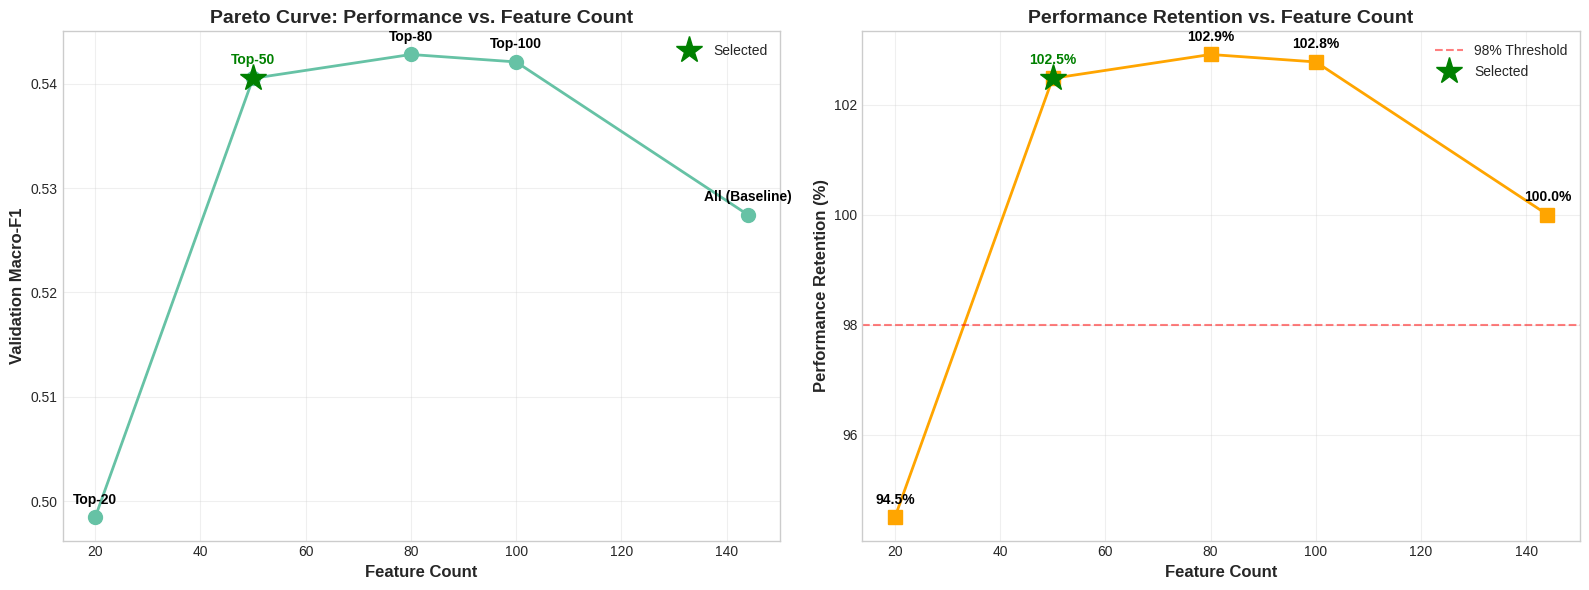

✓ Pareto curve saved


In [20]:
print_subsection("Pareto Curve Visualization")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Performance vs. Feature Count
feature_counts = [v['k'] for v in results['variants'].values()]
val_f1_scores = [v['mean_val_f1'] for v in results['variants'].values()]
variant_names = [v['name'] for v in results['variants'].values()]

ax1.plot(feature_counts, val_f1_scores, 'o-', markersize=10, linewidth=2)
for i, (k, f1, name) in enumerate(zip(feature_counts, val_f1_scores, variant_names)):
    color = 'green' if results['variants'][list(results['variants'].keys())[i]] == selected_variant else 'black'
    ax1.annotate(name, (k, f1), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold', color=color)

# Highlight selected
ax1.plot([selected_variant['k']], [selected_variant['mean_val_f1']], 'g*', markersize=20, label='Selected')

ax1.set_xlabel('Feature Count', fontsize=12, fontweight='bold')
ax1.set_ylabel('Validation Macro-F1', fontsize=12, fontweight='bold')
ax1.set_title('Pareto Curve: Performance vs. Feature Count', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# Plot 2: Retention vs. Feature Count
retentions = [v['retention']*100 for v in results['variants'].values()]

ax2.plot(feature_counts, retentions, 's-', markersize=10, linewidth=2, color='orange')
ax2.axhline(y=98, color='r', linestyle='--', alpha=0.5, label='98% Threshold')
ax2.plot([selected_variant['k']], [selected_variant['retention']*100], 'g*', markersize=20, label='Selected')

for i, (k, ret, name) in enumerate(zip(feature_counts, retentions, variant_names)):
    color = 'green' if results['variants'][list(results['variants'].keys())[i]] == selected_variant else 'black'
    ax2.annotate(f"{ret:.1f}%", (k, ret), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold', color=color)

ax2.set_xlabel('Feature Count', fontsize=12, fontweight='bold')
ax2.set_ylabel('Performance Retention (%)', fontsize=12, fontweight='bold')
ax2.set_title('Performance Retention vs. Feature Count', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig(RESULTS_PLOTS / "exp_0.3_pareto_curve.png", dpi=300, bbox_inches='tight')
plt.show()

print("Pareto curve saved")

### 8.2 Top-50 Feature Importance


------------------------------------------------------------
  Top-50 Feature Importance Visualization
------------------------------------------------------------



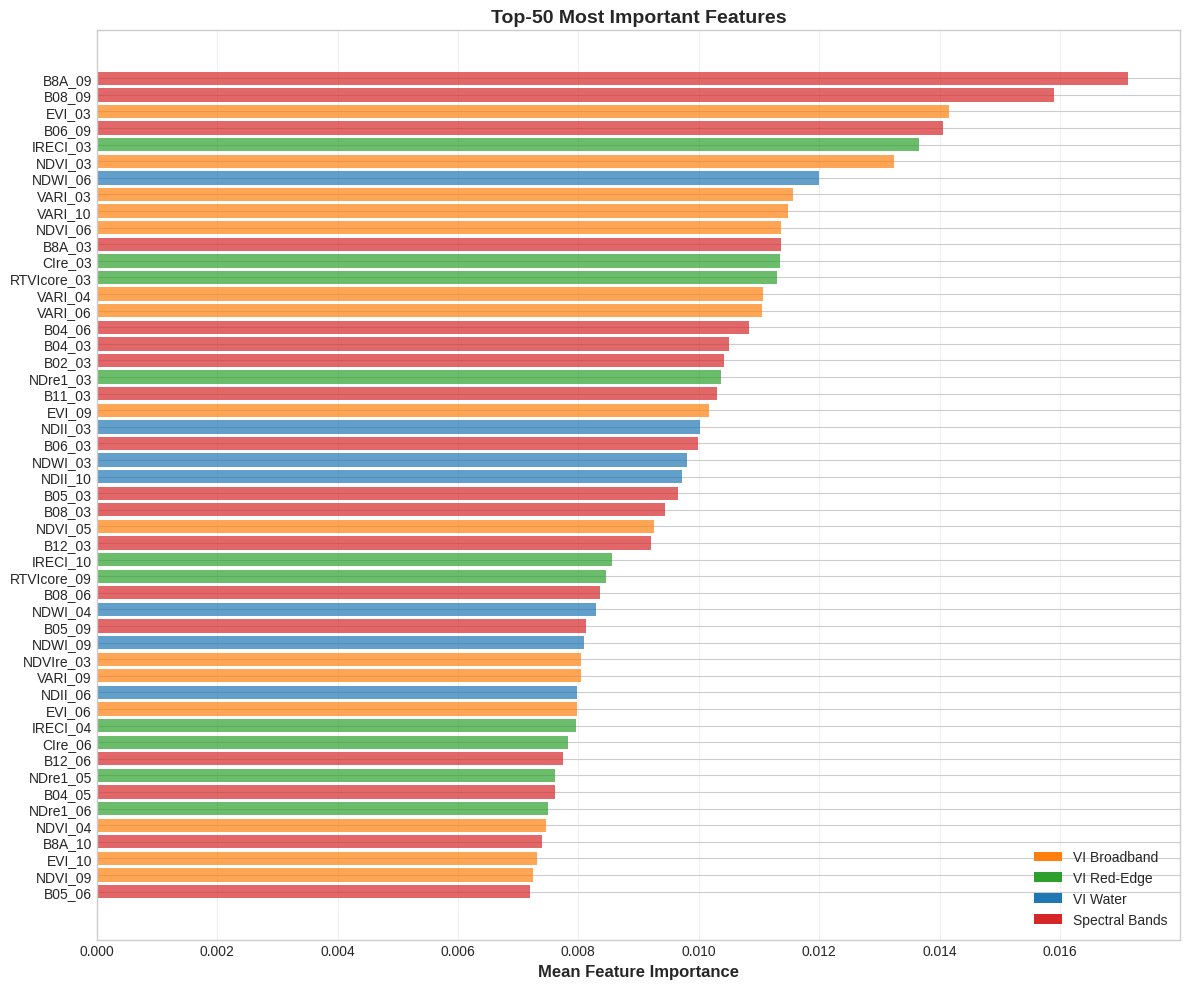

✓ Feature importance plot saved


In [21]:
print_subsection("Top-50 Feature Importance Visualization")

fig, ax = plt.subplots(figsize=(12, 10))

top50_features = ranked_features[:50]
features = [f[0] for f in top50_features]
importances = [f[1] for f in top50_features]

# Color by feature group
colors = []
for feat in features:
    if feat.startswith('VARI') or feat.startswith('NDVI') or feat.startswith('EVI'):
        colors.append('#ff7f0e')  # Orange for broadband VIs
    elif feat.startswith('NDVIre') or feat.startswith('NDre') or feat.startswith('CIre') or feat.startswith('IRECI') or feat.startswith('RTVI'):
        colors.append('#2ca02c')  # Green for red-edge VIs
    elif feat.startswith('NDWI') or feat.startswith('NDII'):
        colors.append('#1f77b4')  # Blue for water VIs
    else:
        colors.append('#d62728')  # Red for spectral bands

bars = ax.barh(range(len(features)), importances, color=colors, alpha=0.7)
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features)
ax.set_xlabel('Mean Feature Importance', fontsize=12, fontweight='bold')
ax.set_title('Top-50 Most Important Features', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#ff7f0e', label='VI Broadband'),
    Patch(facecolor='#2ca02c', label='VI Red-Edge'),
    Patch(facecolor='#1f77b4', label='VI Water'),
    Patch(facecolor='#d62728', label='Spectral Bands')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(RESULTS_PLOTS / "exp_0.3_importance_top50.png", dpi=300, bbox_inches='tight')
plt.show()

print("Feature importance plot saved")

---

## 9. EXPORT RESULTS

### 9.1 Save Full Results

In [22]:
print_section("EXPORT RESULTS")

# Full results
results_file = RESULTS_METADATA / "exp_0.3_results.json"
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)
print(f"Full results saved: {results_file.name}")

# Selected features for Phase 1
selected_features_file = RESULTS_METADATA / "selected_features.json"
with open(selected_features_file, 'w') as f:
    json.dump(decision_record, f, indent=2)
print(f"Selected features saved: {selected_features_file.name}")


  EXPORT RESULTS

✓ Full results saved: exp_0.3_results.json
✓ Selected features saved: selected_features.json


### 9.2 Create Decision Document

In [23]:
print_subsection("Creating Decision Document")

decision_md = f"""# Experiment 0.3: Feature Reduction - Decision

**Date:** {decision_record['timestamp']}
**Selected:** {decision_record['selected_name']} ({decision_record['feature_count']} features)

## Comparison

| Variant | Features | Val F1 | Retention | Gap |
|---------|----------|--------|-----------|-----|
"""

for variant_id in ['A', 'B', 'C', 'D', 'E']:
    v = results['variants'][variant_id]
    mark = " (Selected)" if variant_id == decision else ""
    decision_md += f"| {v['name']}{mark} | {v['k']} | {v['mean_val_f1']:.4f} | {v['retention']*100:.1f}% | {v['mean_gap']*100:.1f}% |\n"

decision_md += f"""
## Reasoning

"""

for reason in decision_record['reasoning']:
    decision_md += f"- {reason}\n"

decision_md += f"""
## Criteria Evaluated

"""

for criterion in decision_record['criteria_evaluated']:
    decision_md += f"### {criterion['criterion']}\n"
    decision_md += f"- Result: {criterion['result']}\n"
    decision_md += f"- Action: {criterion['action']}\n\n"

decision_md += f"""
## Next Steps

- Use {decision_record['feature_count']} selected features for Phase 1
- Feature list saved in: selected_features.json
- Load features: `json.load(open('selected_features.json'))['features']`
"""

decision_file = EXPERIMENT_DIR / "decision_features.md"
with open(decision_file, 'w') as f:
    f.write(decision_md)

print(f"Decision document saved: {decision_file.name}")
print("\n" + decision_md)


------------------------------------------------------------
  Creating Decision Document
------------------------------------------------------------

✓ Decision document saved: decision_features.md

# Experiment 0.3: Feature Reduction - Decision

**Date:** 2026-01-19T17:27:45.549687
**Selected:** Top-50 (50 features)

## Comparison

| Variant | Features | Val F1 | Retention | Gap |
|---------|----------|--------|-----------|-----|
| Top-20 | 20 | 0.4984 | 94.5% | 50.2% |
| Top-50 (Selected) | 50 | 0.5405 | 102.5% | 45.9% |
| Top-80 | 80 | 0.5428 | 102.9% | 45.7% |
| Top-100 | 100 | 0.5421 | 102.8% | 45.8% |
| All (Baseline) | 144 | 0.5275 | 100.0% | 47.3% |

## Reasoning

- Top-50 retains 102.5% performance with 94 fewer features
- Efficiency gain: 65% fewer features

## Criteria Evaluated

### Performance Retention ≥ 98%
- Result: Top-50 has 102.5% retention
- Action: Select B (smallest set with high retention)


## Next Steps

- Use 50 selected features for Phase 1
- Feature list 

---

## 10. SUMMARY

In [24]:
print_section("EXPERIMENT 0.3 COMPLETE")

print(f"Selected Feature Set: {decision_record['selected_name']}")
print(f"  Feature Count: {decision_record['feature_count']} ({decision_record['feature_count']/144*100:.0f}% of baseline)")
print(f"  Baseline Val F1: {decision_record['baseline_f1']:.4f}")
print(f"  Selected Val F1: {decision_record['selected_f1']:.4f}")
print(f"  Retention: {decision_record['retention']*100:.1f}%")

print(f"\nPhase 0 Complete:")
print(f"  Experiment 0.1: CHM Strategy -> No CHM (144 spectral features)")
print(f"  Experiment 0.2: Dataset Selection -> 20m-Edge (6 genera)")
print(f"  Experiment 0.3: Feature Reduction -> {decision_record['selected_name']} ({decision_record['feature_count']} features)")

print(f"\nReady for Phase 1:")
print(f"  - Dataset: berlin_20m_edge (6 genera)")
print(f"  - Features: {decision_record['feature_count']} selected features")
print(f"  - Load: selected_features.json")
print(f"  - Algorithms: RF, XGBoost, CNN, TabNet")

print(f"\nPhase 0 Setup Fixation Complete!")


  EXPERIMENT 0.3 COMPLETE

Selected Feature Set: Top-50
  Feature Count: 50 (35% of baseline)
  Baseline Val F1: 0.5275
  Selected Val F1: 0.5405
  Retention: 102.5%

Phase 0 Complete:
  ✅ Experiment 0.1: CHM Strategy → No CHM (144 spectral features)
  ✅ Experiment 0.2: Dataset Selection → 20m-Edge (6 genera)
  ✅ Experiment 0.3: Feature Reduction → Top-50 (50 features)

Ready for Phase 1:
  - Dataset: berlin_20m_edge (6 genera)
  - Features: 50 selected features
  - Load: selected_features.json
  - Algorithms: RF, XGBoost, CNN, TabNet

🎯 Phase 0 Setup Fixation Complete!
